In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from training.dataset.transforms import ComposeAPI, NormalizeAPI
from tqdm import tqdm

from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset

/home/guests/tuna_gurbuz/prototype


In [3]:
# Dataset
object_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 24, 25, 26, 27, 28, 29]
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
multiview = True
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('train',
                           num_frames=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           multiview=multiview,)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!


5683it [00:02, 1941.39it/s]


Mutual IDs: 1799
Loading the take 003_TKA!


5076it [00:02, 2017.91it/s]


Mutual IDs: 994
Loading the take 005_TKA!


4737it [00:00, 16120.09it/s]


Loading the take 006_PKA!


3706it [00:02, 1813.29it/s]


Mutual IDs: 981
Loading the take 008_PKA!


3513it [00:01, 1807.02it/s]


Mutual IDs: 2679
Loading the take 010_PKA!


2830it [00:00, 3728.93it/s] 


Mutual IDs: 1296
Loading the take 012_1_PKA!


1526it [00:00, 1661.02it/s]


Mutual IDs: 256
Loading the take 035_PKA!


5653it [00:03, 1686.54it/s]


Mutual IDs: 1107
Loading the take 037_TKA!


4237it [00:02, 2068.10it/s]

Lenght of the dataset! 9112


In [4]:
idx = 3 * 1000
test_dataset.images[idx], test_dataset.images[idx+1], test_dataset.images[idx+2], len(test_dataset.images), len(test_dataset)
# test_dataset.segmentation_masks[idx], test_dataset.segmentation_masks[idx+1], test_dataset.segmentation_masks[idx+2], len(test_dataset.segmentation_masks), len(test_dataset)

(array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera01_colorimage-002918.jpg')],
       dtype=object),
 array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera04_colorimage-002918.jpg')],
       dtype=object),
 array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera05_colorimage-002918.jpg')],
       dtype=object),
 27336,
 9112)

In [5]:
for i in range(0, len(test_dataset.images), 3):
    # print(f'Image {i}: {test_dataset.images[i]}')
    # print(f'Image {i+1}: {test_dataset.images[i+1]}')
    # print(f'Image {i+2}: {test_dataset.images[i+2]}')
    # print('---')
    name1 = str(test_dataset.images[i][0]).split('/')[-1].split('_')[0]
    timestamp1 = str(test_dataset.images[i][0]).split('/')[-1].split('_')[1]
    assert name1 == 'camera01'
    name2 = str(test_dataset.images[i+1][0]).split('/')[-1].split('_')[0]
    timestamp2 = str(test_dataset.images[i+1][0]).split('/')[-1].split('_')[1]
    assert name2 == 'camera04'
    name3 = str(test_dataset.images[i+2][0]).split('/')[-1].split('_')[0]
    timestamp3 = str(test_dataset.images[i+2][0]).split('/')[-1].split('_')[1]
    assert name3 == 'camera05'
    assert timestamp1 == timestamp2 == timestamp3

Multiview Point Cloud Registration

In [6]:
cam_int_ext = [(mtrx[0].numpy(), mtrx[1].numpy()) for mtrx in test_dataset.camera_features['001_PKA']]

In [7]:
cam_int = [mtrx[0] for mtrx in cam_int_ext]
cam_ext = [mtrx[1] for mtrx in cam_int_ext]

In [8]:
def process_img(mv_idx, img_indices):
    # Get image path
    img_paths = test_dataset.images[img_indices, :].squeeze(1)  # get image paths for the multiview indices
    # Load video data batch
    video_data_batch = test_dataset[mv_idx]
    # Inverse mean std normalization
    img0 = revert_transform(video_data_batch[0][0].frames[0].data).numpy()
    img1 = revert_transform(video_data_batch[0][1].frames[0].data).numpy()
    img2 = revert_transform(video_data_batch[0][2].frames[0].data).numpy()
    img = (img0, img1, img2)
    # Depth path
    depth_images = []
    for img_path in img_paths:
        last_part = str(img_path.parts[-1].split('/')[-1].replace('.jpg', '.tiff').replace('color', 'depth'))
        depth_path = img_path.parents[1] / 'depthimage' / last_part
        # Load depth image
        gt_depth_image = Image.open(depth_path)
        # Resize depth image to 512x512
        gt_depth_image = gt_depth_image.resize((gt_depth_image.size[0]//2, gt_depth_image.size[1]//2))
        depth_images.append(np.array(gt_depth_image))
    return img, depth_images, depth_path

In [9]:
len_dataset = len(test_dataset)
print(f'Length of the dataset: {len_dataset}')
mv_indices = [1442]  # [700, 1115, 1442]
img_views = []
depth_views = []

for mv_idx in tqdm(mv_indices):
    # Get image path and camera index
    img_indices = [mv_idx * 3 + kk for kk in range(3)]
    img, gt_depth_image, depth_path = process_img(mv_idx, img_indices)
    img = np.stack(img, axis=0)  # Stack images along a new dimension
    gt_depth_image = np.stack(gt_depth_image, axis=0)  # Stack depth images along a new dimension
    H,W = gt_depth_image.shape[-2:]
    buffer = (W-H) // 2
    img = img[:,:, buffer:-buffer, :]
    assert img.shape[-2:] == gt_depth_image.shape[-2:]
    img_views.append(img)
    depth_views.append(gt_depth_image)

Length of the dataset: 9112


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


In [10]:
depth_path, test_dataset.images[img_indices[0]], test_dataset.images[img_indices[1]], test_dataset.images[img_indices[2]]

(PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/depthimage/camera05_depthimage-004777.tiff'),
 array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera01_colorimage-004777.jpg')],
       dtype=object),
 array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera04_colorimage-004777.jpg')],
       dtype=object),
 array([PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera05_colorimage-004777.jpg')],
       dtype=object))

In [11]:
# convert_pil = ToPILImage()

# img_hammer_1 = convert_pil(torch.tensor(img_views[0][1])).save('../temp/img_view_1_hammer.png')
# img_hammer_0 = convert_pil(torch.tensor(img_views[0][0])).save('../temp/img_view_0_hammer.png')
# img_hammer_2 = convert_pil(torch.tensor(img_views[0][2])).save('../temp/img_view_2_hammer.png')

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
for i, im in enumerate(img):
    axs[0, i].imshow(im.transpose(1, 2, 0))  # Change to HxWxC for plotting
    axs[0, i].set_title(f'Image {i+1}')
    axs[0, i].axis('off')
    
    axs[1, i].imshow(gt_depth_image[i], cmap='plasma')  # Change to HxW for plotting
    axs[1, i].set_title(f'Depth {i+1}')
    axs[1, i].axis('off')

Depth Anything

In [ ]:
from transformers import pipeline
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

# pipeline = pipeline("depth-estimation", model="depth-anything/Depth-Anything-V2-Large-hf", device=0)
# depth = pipe(image_DA)["depth"]

# image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
# model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")

image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Metric-Indoor-Large-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Metric-Indoor-Large-hf")

In [ ]:
predicted_depth_list = []

for i in range(3):
    image_DA = Image.fromarray((img_views[0][i].transpose(1, 2, 0) * 255).astype(np.uint8))
    inputs = image_processor(images=image_DA, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    post_processed_output = image_processor.post_process_depth_estimation(
        outputs,
        target_sizes=[(image_DA.height, image_DA.width)],
    )

    predicted_depth = post_processed_output[0]["predicted_depth"]
    predicted_depth_list.append(predicted_depth.cpu().numpy())

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
for i in range(3):
    ax[0, i].imshow(predicted_depth_list[i], cmap='plasma')  # Change to HxW for plotting
    ax[1, i].imshow(depth_views[0][i], cmap='plasma')

In [ ]:
_flag_dump = False
if _flag_dump:
    with open(f'../temp/mv_img_views{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(img_views))
    with open(f'../temp/mv_depth_views{mv_idx}_DA.npy', 'wb') as f:
        np.save(f, np.array(predicted_depth_list)[None,:])
    with open(f'../temp/camera_int{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(cam_int))
    with open(f'../temp/camera_ext{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(cam_ext))

Depth PRO Prediction (NOT A DEPTH COMPLETION)

In [ ]:
if_apple_model = True

In [ ]:
import depth_pro

if if_apple_model:
    config = depth_pro.DEFAULT_MONODEPTH_CONFIG_DICT  # Changed init for this
    config.checkpoint_uri = '/home/guests/tuna_gurbuz/prototype/models/ml-depth-pro/checkpoints/depth_pro.pt'
    model, transform = depth_pro.create_model_and_transforms()
    model.eval()

In [ ]:
if if_apple_model:
    predicted_apple_depth_list = []
    for idx, im in enumerate(img):
        # Preprocess an image
        if im.shape[-2] != gt_depth_image.shape[-2]:
            print('REMOVE PADDING')
            H,W = gt_depth_image.shape[-2:]
            padding = (W-H) // 2
            im = im[:, padding:-padding, :]
        print(f'Image shape: {im.shape}')
        image_transformed = transform(im.transpose(1,2,0))  # Transpose to (H, W, C) for PIL
        f_px = torch.tensor(cam_int[idx][0, 0])  # Focal length in pixels (fx)

        # Run inference
        prediction = model.infer(image_transformed, f_px=f_px)
        depth = prediction["depth"]  # Depth in [mm].
        focallength_px = prediction["focallength_px"]  # Focal length in pixels.
        predicted_apple_depth_list.append(depth.cpu().numpy())

In [ ]:
depth.max(), depth.min(), depth.mean()

In [ ]:
if if_apple_model:
    scale_gt_depth_image = gt_depth_image[0]
    pos = np.where(scale_gt_depth_image >= 100)  # 100 mm threshold
    gt_y = scale_gt_depth_image[pos][:, None] / 1000.0  # Convert to meters
    x = depth.cpu().numpy()[pos][:, None]

    # Linear regression to find the scale factor
    scaling_factor = np.linalg.inv(x.T @ x) @ (x.T @ gt_y)  # It is scaler so leave the np.eye
    print(f'Scaling factor: {scaling_factor}')

    # Apply scaling factor to the predicted depth
    depth_scaled = depth.cpu().numpy() * scaling_factor[0, 0]

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
for i in range(3):
    ax[0, i].imshow(predicted_apple_depth_list[i], cmap='plasma')  # Change to HxW for plotting
    ax[1, i].imshow(depth_views[0][i], cmap='plasma')

In [ ]:
_flag_dump = False
if _flag_dump:
    with open(f'../temp/mv_img_views{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(img_views))
    with open(f'../temp/mv_depth_views{mv_idx}_APPLE.npy', 'wb') as f:
        np.save(f, np.array(predicted_apple_depth_list)[None,:])
    with open(f'../temp/camera_int{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(cam_int))
    with open(f'../temp/camera_ext{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(cam_ext))

In [ ]:
_flag_dump = False
if _flag_dump:
    with open('../temp/mv_img_views.npy', 'wb') as f:
        np.save(f, np.array(img_views))
    with open('../temp/mv_depth_views.npy', 'wb') as f:
        np.save(f, np.array(depth_views))
    with open('../temp/camera_int.npy', 'wb') as f:
        np.save(f, np.array(cam_int))
    with open('../temp/camera_ext.npy', 'wb') as f:
        np.save(f, np.array(cam_ext))

In [ ]:
depth_views[0].shape, depth_views[0].max()

In [ ]:
import requests
prompt_depth_url = "https://github.com/DepthAnything/PromptDA/blob/main/assets/example_images/arkit_depth.png?raw=true"
prompt_depth = Image.open(requests.get(prompt_depth_url, stream=True).raw)

In [12]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

image_processor = AutoImageProcessor.from_pretrained("depth-anything/prompt-depth-anything-vitl-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/prompt-depth-anything-vitl-hf")

predicted_depth_list_PDA = []

for i in range(3):
    image_PDA = Image.fromarray((img_views[0][i].transpose(1, 2, 0) * 255).astype(np.uint8))
    prompt_depth = depth_views[0][i] / 1000.0
    prompt_depth = Image.fromarray(prompt_depth)
    inputs = image_processor(images=image_PDA, return_tensors="pt", prompt_depth=prompt_depth)

    with torch.no_grad():
        outputs = model(**inputs)

    post_processed_output = image_processor.post_process_depth_estimation(
        outputs,
        target_sizes=[(image_PDA.height, image_PDA.width)],
    )

    predicted_depth = post_processed_output[0]["predicted_depth"]
    predicted_depth_list_PDA.append(predicted_depth.cpu().numpy())

# visualize the prediction
predicted_depth = post_processed_output[0]["predicted_depth"]
depth = predicted_depth * 1000 
depth = depth.detach().cpu().numpy()
depth = Image.fromarray(depth.astype("uint16")) # mm

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


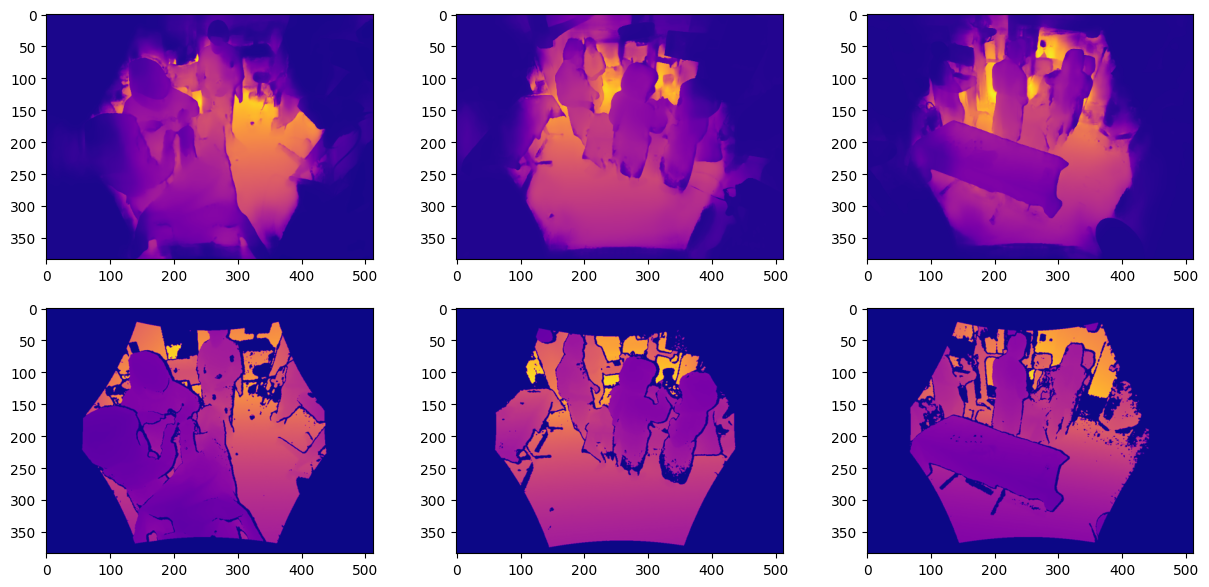

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
for i in range(3):
    ax[0, i].imshow(predicted_depth_list_PDA[i] * 1000, cmap='plasma')  # Change to HxW for plotting
    ax[1, i].imshow(depth_views[0][i], cmap='plasma')

In [ ]:
_flag_dump = False
if _flag_dump:
    with open(f'../temp/mv_img_views{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(img_views))
    with open(f'../temp/mv_depth_views{mv_idx}_PDA.npy', 'wb') as f:
        np.save(f, np.array(predicted_depth_list_PDA)[None,:] * 1000)
    with open(f'../temp/camera_int{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(cam_int))
    with open(f'../temp/camera_ext{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(cam_ext))

Marigold DC

In [ ]:
import logging
import warnings
import diffusers
from diffusers import DDIMScheduler, MarigoldDepthPipeline


warnings.simplefilter(action="ignore", category=FutureWarning)
diffusers.utils.logging.disable_progress_bar()

class MarigoldDepthCompletionPipeline(MarigoldDepthPipeline):
    """
    Pipeline for Marigold Depth Completion.
    Extends the MarigoldDepthPipeline to include depth completion functionality.
    """
    def __call__(
        self, image: Image.Image, sparse_depth: np.ndarray,
        num_inference_steps: int = 50, processing_resolution: int = 768, seed: int = 2024
    ) -> np.ndarray:
        
        """
        Args:
            image (PIL.Image.Image): Input image of shape [H, W] with 3 channels.
            sparse_depth (np.ndarray): Sparse depth guidance of shape [H, W].
            num_inference_steps (int, optional): Number of denoising steps. Defaults to 50.
            processing_resolution (int, optional): Resolution for processing. Defaults to 768.
            seed (int, optional): Random seed. Defaults to 2024.

        Returns:
            np.ndarray: Dense depth prediction of shape [H, W].

        """
        # Resolving variables
        device = self._execution_device
        generator = torch.Generator(device=device).manual_seed(seed)

        # Check inputs.
        if num_inference_steps is None:
            raise ValueError("Invalid num_inference_steps")
        if type(sparse_depth) is not np.ndarray or sparse_depth.ndim != 2:
            raise ValueError("Sparse depth should be a 2D numpy ndarray with zeros at missing positions")

        # Prepare empty text conditioning
        with torch.no_grad():
            if self.empty_text_embedding is None:
                text_inputs = self.tokenizer("", padding="do_not_pad", 
                    max_length=self.tokenizer.model_max_length, truncation=True, return_tensors="pt")
                text_input_ids = text_inputs.input_ids.to(device)
                self.empty_text_embedding = self.text_encoder(text_input_ids)[0]  # [1,2,1024]

        # Preprocess input images
        image, padding, original_resolution = self.image_processor.preprocess(
            image, processing_resolution=processing_resolution, device=device, dtype=self.dtype
        )  # [N,3,PPH,PPW]

        # Check sparse depth dimensions
        if sparse_depth.shape != original_resolution:
            raise ValueError(
                f"Sparse depth dimensions ({sparse_depth.shape}) must match that of the image ({image.shape[-2:]})"
            )
        
        # Encode input image into latent space
        with torch.no_grad():
            image_latent, pred_latent = self.prepare_latents(image, None, generator, 1, 1)  # [N*E,4,h,w], [N*E,4,h,w]
        del image

        # Preprocess sparse depth
        sparse_depth = torch.from_numpy(sparse_depth)[None, None].float().to(device)
        sparse_mask = sparse_depth > 0
        logging.info(f"Using {sparse_mask.int().sum().item()} guidance points")

        # Set up optimization targets and compute the range and lower bound of the sparse depth
        scale, shift = torch.nn.Parameter(torch.ones(1, device=device)), torch.nn.Parameter(torch.ones(1, device=device))
        pred_latent = torch.nn.Parameter(pred_latent)
        sparse_range = (sparse_depth[sparse_mask].max() - sparse_depth[sparse_mask].min()).item() # (cmax − cmin)
        sparse_lower = (sparse_depth[sparse_mask].min()).item() # cmin
        
        # Set up optimizer
        optimizer = torch.optim.Adam([ {"params": [scale, shift], "lr": 0.005},
                                       {"params": [pred_latent] , "lr": 0.05 }])

        def affine_to_metric(depth: torch.Tensor) -> torch.Tensor:
            # Convert affine invariant depth predictions to metric depth predictions using the parametrized scale and shift. See Equation 2 of the paper.
            return (scale**2) * sparse_range * depth + (shift**2) * sparse_lower

        def latent_to_metric(latent: torch.Tensor) -> torch.Tensor:
            # Decode latent to affine invariant depth predictions and subsequently to metric depth predictions.
            affine_invariant_prediction = self.decode_prediction(latent)  # [E,1,PPH,PPW]
            prediction = affine_to_metric(affine_invariant_prediction)
            prediction = self.image_processor.unpad_image(prediction, padding)  # [E,1,PH,PW]
            prediction = self.image_processor.resize_antialias(
                prediction, original_resolution, "bilinear", is_aa=False
            )  # [1,1,H,W]
            return prediction

        def loss_l1l2(input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
            # Compute L1 and L2 loss between input and target.
            out_l1 = torch.nn.functional.l1_loss(input, target)
            out_l2 = torch.nn.functional.mse_loss(input, target)
            out = out_l1 + out_l2
            return out

        # Denoising loop
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        for _, t in enumerate(
            self.progress_bar(self.scheduler.timesteps, desc=f"Marigold-DC steps ({str(device)})...")
        ):
            optimizer.zero_grad()

            # Forward pass through the U-Net
            batch_latent = torch.cat([image_latent, pred_latent], dim=1)  # [1,8,h,w]
            noise = self.unet(
                batch_latent, t, encoder_hidden_states=self.empty_text_embedding, return_dict=False
            )[0]  # [1,4,h,w]

            # Compute pred_epsilon to later rescale the depth latent gradient
            with torch.no_grad():
                alpha_prod_t = self.scheduler.alphas_cumprod[t]
                beta_prod_t = 1 - alpha_prod_t
                pred_epsilon = (alpha_prod_t**0.5) * noise + (beta_prod_t**0.5) * pred_latent

            step_output = self.scheduler.step(noise, t, pred_latent, generator=generator)

            # Preview the final output depth with Tweedie's formula (See Equation 1 of the paper)
            pred_original_sample = step_output.pred_original_sample

            # Decode to metric space, compute loss with guidance and backpropagate
            current_metric_estimate = latent_to_metric(pred_original_sample)
            loss = loss_l1l2(current_metric_estimate[sparse_mask], sparse_depth[sparse_mask])
            loss.backward()

            # Scale gradients up
            with torch.no_grad():
                pred_epsilon_norm = torch.linalg.norm(pred_epsilon).item()
                depth_latent_grad_norm = torch.linalg.norm(pred_latent.grad).item()
                scaling_factor = pred_epsilon_norm / max(depth_latent_grad_norm, 1e-8)
                pred_latent.grad *= scaling_factor

            # Execute the update step through guidance backprop
            optimizer.step()

            # Execute update of the latent with regular denoising diffusion step
            with torch.no_grad():
                pred_latent.data = self.scheduler.step(noise, t, pred_latent, generator=generator).prev_sample

            del pred_original_sample, current_metric_estimate, step_output, pred_epsilon, noise
            torch.cuda.empty_cache()

        del image_latent

        # Decode predictions from latent into pixel space
        with torch.no_grad():
            prediction = latent_to_metric(pred_latent.detach())

        # return Numpy array
        prediction = self.image_processor.pt_to_numpy(prediction)  # [N,H,W,1]
        self.maybe_free_model_hooks()

        return prediction.squeeze()


In [ ]:
DEPTH_CHECKPOINT = "prs-eth/marigold-depth-v1-0"
num_inference_steps = 75  # 50
processing_resolution = 768

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    processing_resolution_non_cuda = 512
    num_inference_steps_non_cuda = 10
    if processing_resolution > processing_resolution_non_cuda:
        logging.warning(f"CUDA not found: Reducing processing_resolution to {processing_resolution_non_cuda}")
        processing_resolution = processing_resolution_non_cuda
    if num_inference_steps > num_inference_steps_non_cuda:
        logging.warning(f"CUDA not found: Reducing num_inference_steps to {num_inference_steps_non_cuda}")
        num_inference_steps = num_inference_steps_non_cuda

pipe = MarigoldDepthCompletionPipeline.from_pretrained(DEPTH_CHECKPOINT, prediction_type="depth").to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

if not torch.cuda.is_available():
    logging.warning("CUDA not found: Using a lightweight VAE")
    del pipe.vae
    pipe.vae = diffusers.AutoencoderTiny.from_pretrained("madebyollin/taesd").to(device)

pred_list_marigold = []
convert_pil = ToPILImage()
for i in range(3):
    pred = pipe(
        image=convert_pil(img_views[0][i].transpose(1, 2, 0)),
        sparse_depth=gt_depth_image[i] / 1000.0,  # Convert it to meters
        num_inference_steps=num_inference_steps,
        processing_resolution=processing_resolution,
    )
    pred_list_marigold.append(pred)


In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
for i in range(3):
    ax[0, i].imshow(pred_list_marigold[i] * 1000, cmap='plasma')  # Change to HxW for plotting
    ax[1, i].imshow(depth_views[0][i], cmap='plasma')

Least Squares Fit for the prediction metric

In [ ]:
for i in range(3):
    y_depth = gt_depth_image[i]
    pos = np.where(y_depth >= 200)  # 100 mm threshold
    gt_y = y_depth[pos][:, None] / 1000.0
    x = pred[pos][:, None]

    # Linear regression to find the scale factor
    scaling_factor = np.linalg.inv(x.T @ x) @ (x.T @ gt_y)  # It is scaler so leave the np.eye
    print(f'Scaling factor: {scaling_factor}')

    # Apply scaling factor to the predicted depth
    pred_scaled = pred * scaling_factor[0, 0]

    # Check MSE
    se = (x * scaling_factor - gt_y) ** 2
    mse = np.mean(se)
    print(f'Mean Squared Error: {mse}')
    print(f'Max Error: {se.max()}')
    pos_max = se.argmax()
    print(f'Max Error Position: {pos_max}, Predicted: {x[pos_max]}, GT: {gt_y[pos_max]}')

In [ ]:
_flag_dump = False
if _flag_dump:
    with open(f'../temp/mv_img_views{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(img_views))
    with open(f'../temp/mv_depth_views{mv_idx}_MarigoldDC.npy', 'wb') as f:
        np.save(f, np.array(pred_list_marigold)[None,:])
    with open(f'../temp/camera_int{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(cam_int))
    with open(f'../temp/camera_ext{mv_idx}.npy', 'wb') as f:
        np.save(f, np.array(cam_ext))